In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Logo Generation using LSTM GANs

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from PIL import Image
import io

In [3]:
# Load the dataset from Parquet file
df = pd.read_parquet('/content/drive/MyDrive/GansData/train-00000-of-00001-b64601da56687a05.parquet')

# Shorten the dataset to 800 images and corresponding text entries
shortened_df = df.head(800)


In [4]:
# Preprocess the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(shortened_df['text'])
vocab_size = len(tokenizer.word_index) + 1
max_length = 100

# Convert text to sequences
text_sequences = tokenizer.texts_to_sequences(shortened_df['text'])
padded_text_sequences = pad_sequences(text_sequences, maxlen=max_length, padding='post')

# Preprocess the images
def preprocess_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes['bytes']))  # Open image from bytes
    image = image.convert('RGB')  # Convert to RGB format if necessary
    image = image.resize((64, 64))  # Resize image
    image = np.array(image)  # Convert PIL image to numpy array
    image = image.astype(np.float32) / 255.0  # Convert pixel values to [0, 1]
    return image

# Convert image bytes to numpy arrays
images = np.array([preprocess_image(image) for image in shortened_df['image']])



In [9]:

# Define the Generator network
from tensorflow.keras import layers, models

def build_generator(max_length, vocab_size, noise_dim):
    embedding_dim = 128

    noise_dim = 100

    input_text = layers.Input(shape=(max_length,))
    input_noise = layers.Input(shape=(noise_dim,))

    # Text embedding
    text_embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(input_text)
    lstm = layers.LSTM(256)(text_embedding)  # LSTM layer to capture sequential information
    noise_dense = layers.Dense(256)(input_noise)

    # Concatenate text and noise inputs
    concatenated = layers.Concatenate()([lstm, noise_dense])

    # Generator layers
    x = layers.Dense(256 * 8 * 8, activation='relu')(concatenated)
    x = layers.Reshape((8, 8, 256))(x)
    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    generator_output = layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='sigmoid')(x)

    generator_model = models.Model(inputs=[input_text, input_noise], outputs=generator_output)

    return generator_model


In [10]:

def build_discriminator(max_length, vocab_size):
    embedding_dim = 128

    input_image = layers.Input(shape=(64, 64, 3))
    input_text = layers.Input(shape=(max_length,))

    # Image embedding layers
    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(input_image)
    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    image_embedding = layers.Flatten()(x)

    # Text embedding
    text_embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(input_text)
    lstm = layers.LSTM(256)(text_embedding)  # LSTM layer to capture sequential information

    # Concatenate image and text embeddings
    concatenated = layers.Concatenate()([image_embedding, lstm])

    # Discriminator layers
    x = layers.Dense(256, activation='relu')(concatenated)
    discriminator_output = layers.Dense(1, activation='sigmoid')(x)

    discriminator_model = models.Model(inputs=[input_image, input_text], outputs=discriminator_output)

    return discriminator_model


In [11]:
# Define the conditional gan model
def build_cgan(generator, discriminator):
    input_text = layers.Input(shape=(max_length,))
    input_noise = layers.Input(shape=(noise_dim,))

    fake_image = generator([input_text, input_noise])
    validity = discriminator([fake_image, input_text])

    cgan = models.Model(inputs=[input_text, input_noise], outputs=validity)

    return cgan

In [13]:
noise_dim = 100
# Instantiate the models
generator = build_generator(max_length, vocab_size, noise_dim)
discriminator = build_discriminator(max_length, vocab_size)
cgan = build_cgan(generator, discriminator)

# Compile the models
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cgan.compile(optimizer='adam', loss='binary_crossentropy')


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 18ms/step
Epoch 26/75, Batch 1/50, Discriminator Loss: 0.3065401017665863, Generator Loss: 0.780559778213501
1/1 [==============================] - 0s 21ms/step
Epoch 26/75, Batch 2/50, Discriminator Loss: 0.3064827024936676, Generator Loss: 0.7806955575942993
1/1 [==============================] - 0s 26ms/step
Epoch 26/75, Batch 3/50, Discriminator Loss: 0.30642530322074896, Generator Loss: 0.7808313369750977
1/1 [==============================] - 0s 18ms/step
Epoch 26/75, Batch 4/50, Discriminator Loss: 0.3063679039478302, Generator Loss: 0.7809671759605408
1/1 [==============================] - 0s 18ms/step
Epoch 26/75, Batch 5/50, Discriminator Loss: 0.30631050467494675, Generator Loss: 0.7811029553413391
1/1 [==============================] - 0s 24ms/step
Epoch 26/75, Batch 6/50, Discriminator Loss: 0.3062531352043152, Generator Loss: 0.7812387943267822
1/1 [==============================]

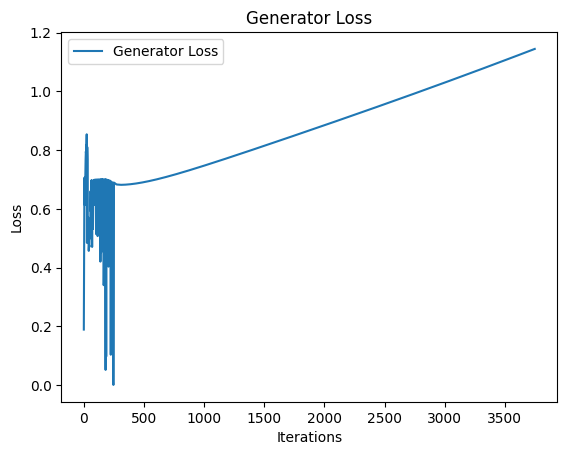

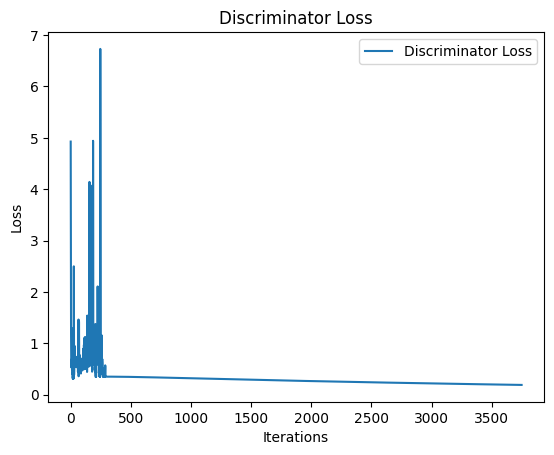

In [14]:

import matplotlib.pyplot as plt

# Train the GAN models
def train_gan(generator, discriminator, cgan, images, text_embeddings, noise_dim, epochs=75, batch_size=16):
    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        for batch_start in range(0, len(images), batch_size):
            # Generate noise
            noise = np.random.normal(0, 1, (batch_size, noise_dim))

            # Select a random batch of images and text embeddings
            real_images_batch = images[batch_start:batch_start+batch_size]
            real_text_embeddings_batch = text_embeddings[batch_start:batch_start+batch_size]

            # Generate fake images from noise and text embeddings
            generated_images = generator.predict([real_text_embeddings_batch, noise])

            # Train the Discriminator
            discriminator_loss_real = discriminator.train_on_batch([real_images_batch, real_text_embeddings_batch], np.ones((batch_size, 1)))
            discriminator_loss_fake = discriminator.train_on_batch([generated_images, real_text_embeddings_batch], np.zeros((batch_size, 1)))
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

            # Train the Generator (via cGAN)
            noise = np.random.normal(0, 1, (batch_size, noise_dim))  # Generate new noise for training Generator
            cgan_loss = cgan.train_on_batch([real_text_embeddings_batch, noise], np.ones((batch_size, 1)))

            # Store loss values
            generator_losses.append(cgan_loss)
            discriminator_losses.append(discriminator_loss[0])

            # Print training progress
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_start//batch_size+1}/{len(images)//batch_size}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {cgan_loss}")

    # Plot loss curves
    plt.plot(generator_losses, label="Generator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Generator Loss")
    plt.legend()
    plt.show()

    plt.plot(discriminator_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Discriminator Loss")
    plt.legend()
    plt.show()




# Train the GAN models
train_gan(generator, discriminator, cgan, images, padded_text_sequences, noise_dim)


In [15]:
def generate_image(generator_model, text_description, noise_dim, max_length, tokenizer):
    # Tokenize and pad the text description
    text_sequence = tokenizer.texts_to_sequences([text_description])
    padded_text_sequence = pad_sequences(text_sequence, maxlen=max_length, padding='post')

    # Generate noise
    noise = np.random.normal(0, 1, (1, noise_dim))

    # Generate image
    generated_image = generator_model.predict([padded_text_sequence, noise])

    return generated_image

# Example usage:
generated_image = generate_image(generator, "a logo of coffee shop, take-away coffee cardboard glass with white and brown stripes and dark brown lid, coffee circle with three cream drops, white background, brown foreground, minimalism, modern", noise_dim, max_length, tokenizer)


1/1 [==============================] - 0s 202ms/step


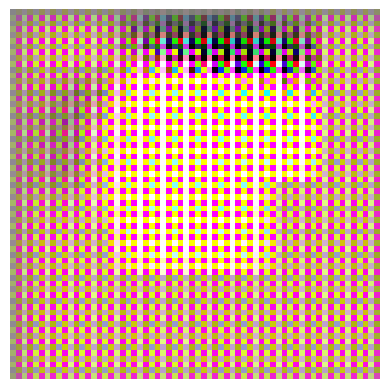

In [16]:
import matplotlib.pyplot as plt

def display_generated_image(image):
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage:
display_generated_image(generated_image[0])


Now with 50 epochs

1/1 [==============================] - 0s 24ms/step
Epoch 1/50, Batch 1/50, Discriminator Loss: 0.19160205125808716, Generator Loss: 1.145146369934082
1/1 [==============================] - 0s 20ms/step
Epoch 1/50, Batch 2/50, Discriminator Loss: 0.1915653795003891, Generator Loss: 1.1453033685684204
1/1 [==============================] - 0s 20ms/step
Epoch 1/50, Batch 3/50, Discriminator Loss: 0.19152872264385223, Generator Loss: 1.1454604864120483
1/1 [==============================] - 0s 19ms/step
Epoch 1/50, Batch 4/50, Discriminator Loss: 0.19149208068847656, Generator Loss: 1.1456174850463867
1/1 [==============================] - 0s 18ms/step
Epoch 1/50, Batch 5/50, Discriminator Loss: 0.1914554387331009, Generator Loss: 1.1457746028900146
1/1 [==============================] - 0s 22ms/step
Epoch 1/50, Batch 6/50, Discriminator Loss: 0.19141879677772522, Generator Loss: 1.1459317207336426
1/1 [==============================] - 0s 19ms/step
Epoch 1/50, Batch 7/50, Discriminator L

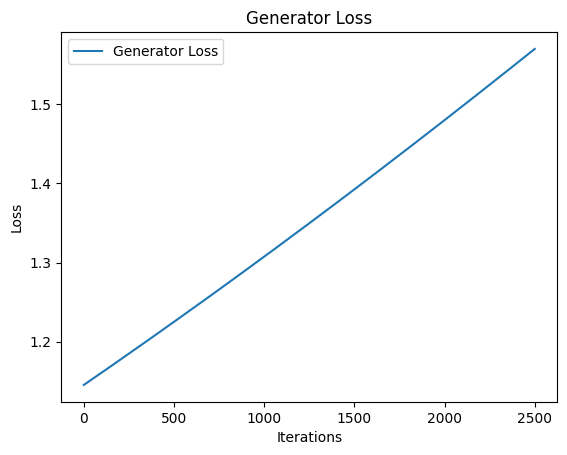

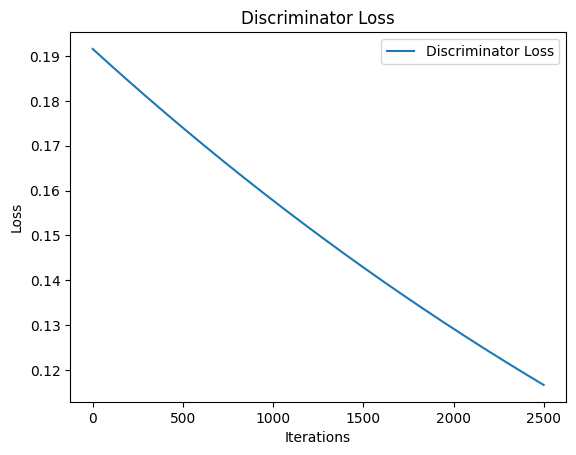

In [17]:
# Train the GAN models
def train_gan(generator, discriminator, cgan, images, text_embeddings, noise_dim, epochs=50, batch_size=16):
    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        for batch_start in range(0, len(images), batch_size):
            # Generate noise
            noise = np.random.normal(0, 1, (batch_size, noise_dim))

            # Select a random batch of images and text embeddings
            real_images_batch = images[batch_start:batch_start+batch_size]
            real_text_embeddings_batch = text_embeddings[batch_start:batch_start+batch_size]

            # Generate fake images from noise and text embeddings
            generated_images = generator.predict([real_text_embeddings_batch, noise])

            # Train the Discriminator
            discriminator_loss_real = discriminator.train_on_batch([real_images_batch, real_text_embeddings_batch], np.ones((batch_size, 1)))
            discriminator_loss_fake = discriminator.train_on_batch([generated_images, real_text_embeddings_batch], np.zeros((batch_size, 1)))
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

            # Train the Generator (via cGAN)
            noise = np.random.normal(0, 1, (batch_size, noise_dim))  # Generate new noise for training Generator
            cgan_loss = cgan.train_on_batch([real_text_embeddings_batch, noise], np.ones((batch_size, 1)))

            # Store loss values
            generator_losses.append(cgan_loss)
            discriminator_losses.append(discriminator_loss[0])

            # Print training progress
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_start//batch_size+1}/{len(images)//batch_size}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {cgan_loss}")

    # Plot loss curves
    plt.plot(generator_losses, label="Generator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Generator Loss")
    plt.legend()
    plt.show()

    plt.plot(discriminator_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Discriminator Loss")
    plt.legend()
    plt.show()




# Train the GAN models
train_gan(generator, discriminator, cgan, images, padded_text_sequences, noise_dim)


In [18]:
def generate_image(generator_model, text_description, noise_dim, max_length, tokenizer):
    # Tokenize and pad the text description
    text_sequence = tokenizer.texts_to_sequences([text_description])
    padded_text_sequence = pad_sequences(text_sequence, maxlen=max_length, padding='post')

    # Generate noise
    noise = np.random.normal(0, 1, (1, noise_dim))

    # Generate image
    generated_image = generator_model.predict([padded_text_sequence, noise])

    return generated_image

# Example usage:
generated_image = generate_image(generator, "a logo of coffee shop, take-away coffee cardboard glass with white and brown stripes and dark brown lid, coffee circle with three cream drops, white background, brown foreground, minimalism, modern", noise_dim, max_length, tokenizer)


1/1 [==============================] - 0s 20ms/step


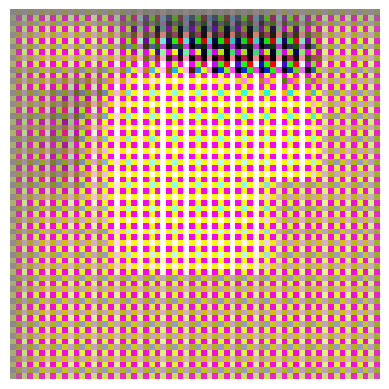

In [19]:
import matplotlib.pyplot as plt

def display_generated_image(image):
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage:
display_generated_image(generated_image[0])


Now with 15 epochs

1/1 [==============================] - 0s 26ms/step
Epoch 1/15, Batch 1/50, Discriminator Loss: 0.1166386753320694, Generator Loss: 1.5704346895217896
1/1 [==============================] - 0s 19ms/step
Epoch 1/15, Batch 2/50, Discriminator Loss: 0.1166146919131279, Generator Loss: 1.5706173181533813
1/1 [==============================] - 0s 21ms/step
Epoch 1/15, Batch 3/50, Discriminator Loss: 0.1165907084941864, Generator Loss: 1.5707999467849731
1/1 [==============================] - 0s 23ms/step
Epoch 1/15, Batch 4/50, Discriminator Loss: 0.1165667399764061, Generator Loss: 1.570982575416565
1/1 [==============================] - 0s 20ms/step
Epoch 1/15, Batch 5/50, Discriminator Loss: 0.1165427714586258, Generator Loss: 1.5711652040481567
1/1 [==============================] - 0s 21ms/step
Epoch 1/15, Batch 6/50, Discriminator Loss: 0.11651879549026489, Generator Loss: 1.5713478326797485
1/1 [==============================] - 0s 27ms/step
Epoch 1/15, Batch 7/50, Discriminator Loss

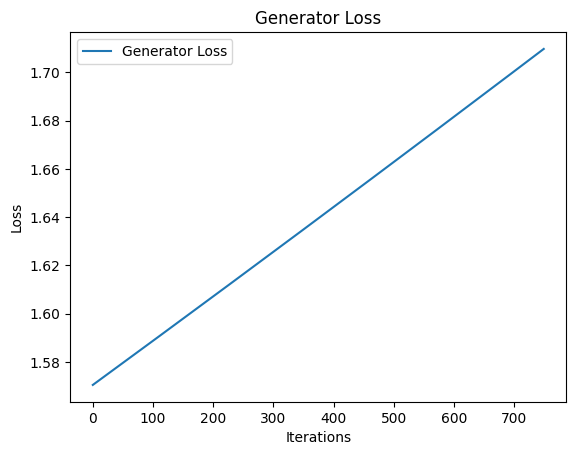

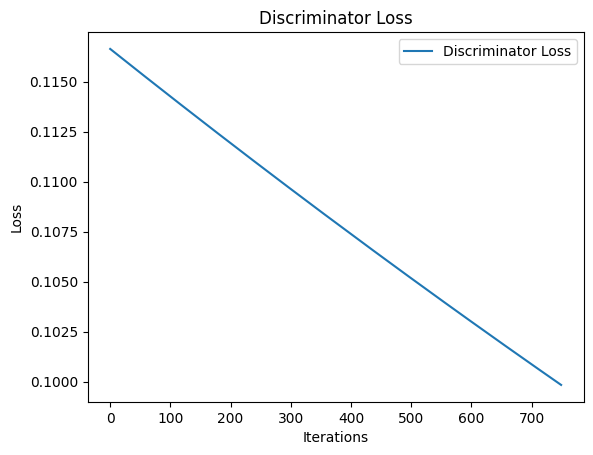

In [20]:
# Train the GAN models
def train_gan(generator, discriminator, cgan, images, text_embeddings, noise_dim, epochs=15, batch_size=16):
    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        for batch_start in range(0, len(images), batch_size):
            # Generate noise
            noise = np.random.normal(0, 1, (batch_size, noise_dim))

            # Select a random batch of images and text embeddings
            real_images_batch = images[batch_start:batch_start+batch_size]
            real_text_embeddings_batch = text_embeddings[batch_start:batch_start+batch_size]

            # Generate fake images from noise and text embeddings
            generated_images = generator.predict([real_text_embeddings_batch, noise])

            # Train the Discriminator
            discriminator_loss_real = discriminator.train_on_batch([real_images_batch, real_text_embeddings_batch], np.ones((batch_size, 1)))
            discriminator_loss_fake = discriminator.train_on_batch([generated_images, real_text_embeddings_batch], np.zeros((batch_size, 1)))
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

            # Train the Generator (via cGAN)
            noise = np.random.normal(0, 1, (batch_size, noise_dim))  # Generate new noise for training Generator
            cgan_loss = cgan.train_on_batch([real_text_embeddings_batch, noise], np.ones((batch_size, 1)))

            # Store loss values
            generator_losses.append(cgan_loss)
            discriminator_losses.append(discriminator_loss[0])

            # Print training progress
            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_start//batch_size+1}/{len(images)//batch_size}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {cgan_loss}")

    # Plot loss curves
    plt.plot(generator_losses, label="Generator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Generator Loss")
    plt.legend()
    plt.show()

    plt.plot(discriminator_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Discriminator Loss")
    plt.legend()
    plt.show()




# Train the GAN models
train_gan(generator, discriminator, cgan, images, padded_text_sequences, noise_dim)


In [21]:
def generate_image(generator_model, text_description, noise_dim, max_length, tokenizer):
    # Tokenize and pad the text description
    text_sequence = tokenizer.texts_to_sequences([text_description])
    padded_text_sequence = pad_sequences(text_sequence, maxlen=max_length, padding='post')

    # Generate noise
    noise = np.random.normal(0, 1, (1, noise_dim))

    # Generate image
    generated_image = generator_model.predict([padded_text_sequence, noise])

    return generated_image

# Example usage:
generated_image = generate_image(generator, "a logo of coffee shop, take-away coffee cardboard glass with white and brown stripes and dark brown lid, coffee circle with three cream drops, white background, brown foreground, minimalism, modern", noise_dim, max_length, tokenizer)


1/1 [==============================] - 0s 20ms/step


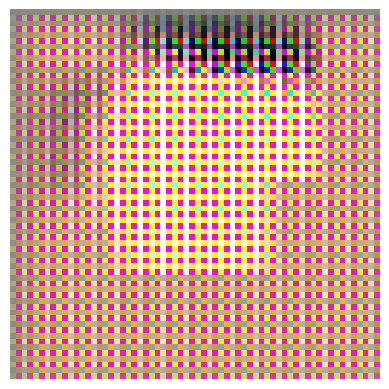

In [22]:
import matplotlib.pyplot as plt

def display_generated_image(image):
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage:
display_generated_image(generated_image[0])
